# Carregamento dos dados

In [258]:
import pandas as pd

df = pd.read_csv("data/ufc-master.csv")

In [259]:
df.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Alex Pereira,Jamahal Hill,-130.0,110.0,76.9231,110.0000,2024-04-13,"Las Vegas, Nevada, USA",USA,Red,...,Punch,1.0,3:14,194.0,600.0,650.0,2000.0,1400.0,110.0,200.0
1,Zhang Weili,Yan Xiaonan,-455.0,350.0,21.9780,350.0000,2024-04-13,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,200.0,NaN,400.0,NaN,140.0,NaN
2,Justin Gaethje,Max Holloway,-185.0,154.0,54.0541,154.0000,2024-04-13,"Las Vegas, Nevada, USA",USA,Blue,...,Punch,5.0,4:59,1499.0,300.0,250.0,2200.0,1600.0,150.0,550.0
3,Charles Oliveira,Arman Tsarukyan,190.0,-218.0,190.0000,45.8716,2024-04-13,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,900.0,330.0,450.0,700.0,550.0,130.0
4,Bo Nickal,Cody Brundage,-1600.0,900.0,6.2500,900.0000,2024-04-13,"Las Vegas, Nevada, USA",USA,Red,...,Rear Naked Choke,2.0,3:38,518.0,1000.0,3000.0,-135.0,3000.0,150.0,1400.0


# Análise e tratamento dos dados

In [260]:
list(df.columns)

['RedFighter',
 'BlueFighter',
 'RedOdds',
 'BlueOdds',
 'RedExpectedValue',
 'BlueExpectedValue',
 'Date',
 'Location',
 'Country',
 'Winner',
 'TitleBout',
 'WeightClass',
 'Gender',
 'NumberOfRounds',
 'BlueCurrentLoseStreak',
 'BlueCurrentWinStreak',
 'BlueDraws',
 'BlueAvgSigStrLanded',
 'BlueAvgSigStrPct',
 'BlueAvgSubAtt',
 'BlueAvgTDLanded',
 'BlueAvgTDPct',
 'BlueLongestWinStreak',
 'BlueLosses',
 'BlueTotalRoundsFought',
 'BlueTotalTitleBouts',
 'BlueWinsByDecisionMajority',
 'BlueWinsByDecisionSplit',
 'BlueWinsByDecisionUnanimous',
 'BlueWinsByKO',
 'BlueWinsBySubmission',
 'BlueWinsByTKODoctorStoppage',
 'BlueWins',
 'BlueStance',
 'BlueHeightCms',
 'BlueReachCms',
 'BlueWeightLbs',
 'RedCurrentLoseStreak',
 'RedCurrentWinStreak',
 'RedDraws',
 'RedAvgSigStrLanded',
 'RedAvgSigStrPct',
 'RedAvgSubAtt',
 'RedAvgTDLanded',
 'RedAvgTDPct',
 'RedLongestWinStreak',
 'RedLosses',
 'RedTotalRoundsFought',
 'RedTotalTitleBouts',
 'RedWinsByDecisionMajority',
 'RedWinsByDecisionSpl

In [261]:
# Balanceamento do dataset

classe_majoritaria = df[df['Winner'] == 'Red']
classe_minoritaria = df[df['Winner'] == 'Blue']

# Fazer undersampling na classe majoritária
classe_majoritaria_subamostrada = classe_majoritaria.sample(len(classe_minoritaria), random_state=42)

df = pd.concat([classe_majoritaria_subamostrada, classe_minoritaria])
df = df.sample(frac=1, random_state=42)
print(df['Winner'].value_counts())


Winner
Red     2586
Blue    2586
Name: count, dtype: int64


In [262]:
def tosecs(x):
    if type(x) == str:
        a, b = x.split(':')
        return int(a) * 60 + int(b)
    return 25 * 60

df["FinishRoundTime"] = df["FinishRoundTime"].apply(tosecs)

In [263]:
# Remoção de colunas não numéricas

df = df.drop(columns=["Date", "Location", "Country", "RedFighter", "BlueFighter", "FinishRoundTime", "FinishDetails", "Finish"])

In [264]:
def make_dummy(df, column):
    df = df.copy()

    classes = df[column].unique()

    for c in classes:
        df[f'{column}_{c}'] = df[column].map(lambda x: 1 if x == c else 0)
    
    df = df.drop(columns=[column])
    return df

In [265]:
# Tratar coluna de dados de ranking

rank_columns = list(filter(lambda x: x.endswith('Rank'), list(df.columns)))
rank_columns.remove("BetterRank")

for c in rank_columns:
    df.loc[df[c].notnull(), "Rank"]  = df[c]
    df.loc[df[c].notna(), "Rank"]  = df[c]

df.drop(columns=rank_columns, inplace=True)
df.loc[df["Rank"].isna(), "Rank"] = 20

### Seleção de atributos
- Gender
- Winner (Red, Blue)
- WeightClass
- BlueStance
- RedStance
- BetterRank (Red, Blue, neither)

In [266]:
weight_classes = {
    'Flyweight': 56.7,
    'Bantamweight': 61.2,
    'Featherweight': 65.7,
    'Lightweight': 70.3,
    'Welterweight': 77.1,
    'Middleweight': 83.9,
    'Light Heavyweight': 92.9,
    'Heavyweight': 120.2,
    'Catch Weight': None,  # Pesos variam dependendo do acordo
    "Women's Strawweight": 52.1,
    "Women's Flyweight": 56.7,
    "Women's Bantamweight": 61.2,
    "Women's Featherweight": 65.7
}

In [267]:
def categoria_mais_proxima(peso):
    weight_classes = {
        'Flyweight': 56.7,
        'Bantamweight': 61.2,
        'Featherweight': 65.7,
        'Lightweight': 70.3,
        'Welterweight': 77.1,
        'Middleweight': 83.9,
        'Light Heavyweight': 92.9,
        'Heavyweight': 120.2,
    }
    
    # Inicializa a categoria mais próxima e a menor diferença
    categoria_proxima = None
    menor_diferenca = float('inf')

    for categoria, limite in weight_classes.items():
        diferenca = abs(limite - peso)
        if diferenca < menor_diferenca:
            menor_diferenca = diferenca
            categoria_proxima = categoria

    return weight_classes[categoria_proxima]

In [268]:
df = make_dummy(df, "Gender")
df = make_dummy(df, "BlueStance")
df = make_dummy(df, "RedStance")

df["Winner"] = df["Winner"].map(lambda x: 1 if x == "Red" else 0)
df["BetterRank"] = df["BetterRank"].map(lambda x: 1 if x == "Red" else (0 if x == "neither" else -1) )
df["WeightClass"] = df["WeightClass"].map(lambda x: weight_classes[x])

catch = df["WeightClass"] == None
mean_weight = (df.loc[catch, "RedWeightLbs"] * 0.5 +  df.loc[catch, "BlueWeightLbs"] * 0.5) * 0.453592
df.loc[catch, "WeightClass"] = mean_weight.map(lambda x: categoria_mais_proxima)

In [269]:
df["WeightClass"]

5262    120.2
4180     61.2
3768     77.1
1613     56.7
2026     56.7
        ...  
4326     83.9
2867     70.3
1193     56.7
2825     70.3
3702     52.1
Name: WeightClass, Length: 5172, dtype: float64

In [270]:
# Tratar dados nulos e NaN
# Usar média para tratar dados faltantes
for c in df.columns:
    mean = df[c].mean()
    df.loc[df[c].isna(), c] = mean
    df.loc[df[c].isnull(), c] = mean


/tmp/ipykernel_3532/3616722284.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[c].isna(), c] = mean
/tmp/ipykernel_3532/3616722284.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.04621036349574632' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df[c].isna(), c] = mean
/tmp/ipykernel_3532/3616722284.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.1842614075792732' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[c].isna(), c] = mean
/tmp/ipykernel_3532/3616722284.py:5: FutureWarning: Setting an item of incompatible dtype is depr

<Axes: >

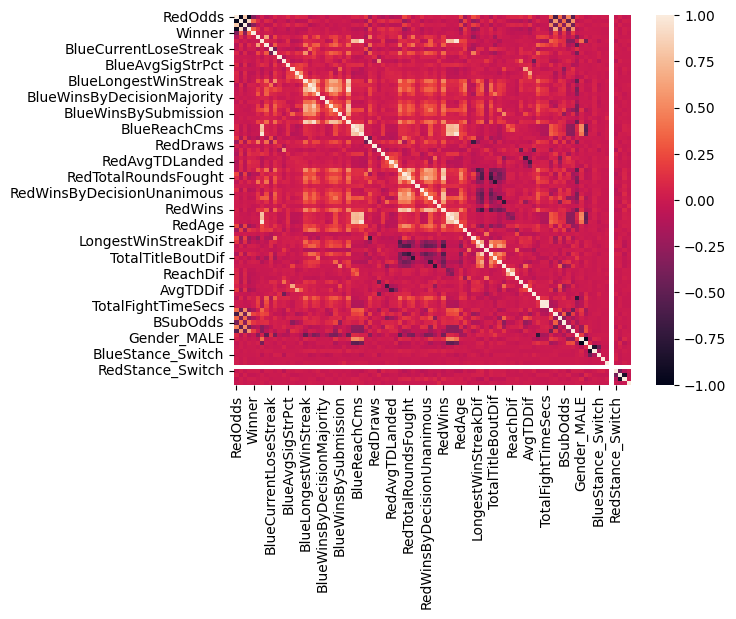

In [271]:
# Plotar mapa de correlação

import seaborn as sns
sns.heatmap(df.corr())

In [272]:
# Remover colunas com baixa correlação com variável alvo

mask = abs(df.corr()["Winner"]) > 0.03
df = df.loc[:, mask]

<Axes: >

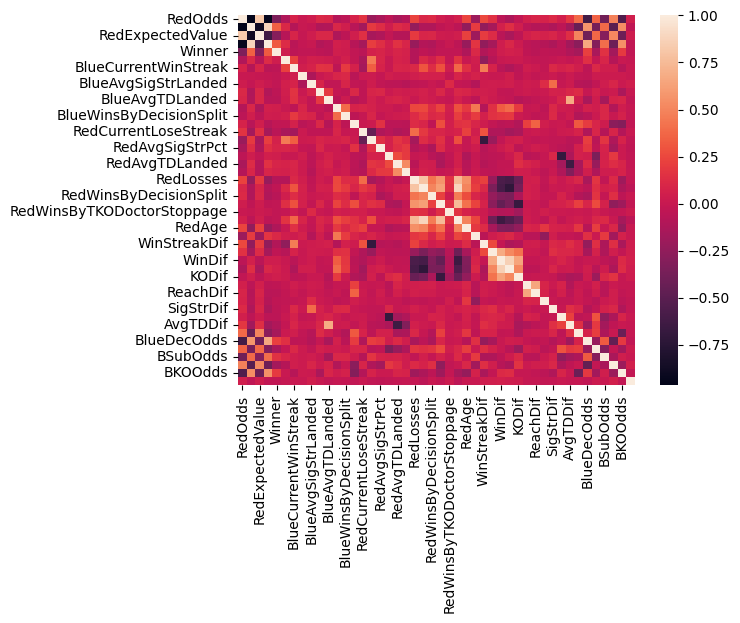

In [273]:
# Plotar heatmap

sns.heatmap(df.corr())

<Axes: >

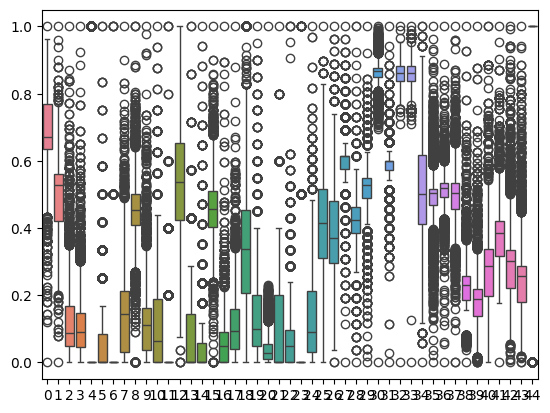

In [274]:
# Análise de outliers

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X=df.drop(columns=["Winner"]), y=df["Winner"])
x = scaler.transform(df.drop(columns=["Winner"]))
sns.boxplot(x)

<Axes: >

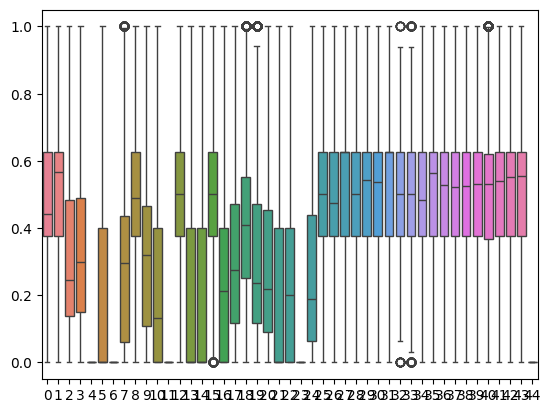

In [275]:
# Normalização e remoção de outliers

def remove_outliers(df, columns):
    df_ = df.copy() 

    for column in columns:
        q1 = df_[column].quantile(0.25)  # primeiro quartil
        q3 = df_[column].quantile(0.75)  # terceiro quartil
        iqr = q3 - q1

        low_lim = q1 - 1.5 * iqr
        high_lim = q3 + 1.5 * iqr

        # Substitui valores menores que o limite inferior pelo limite inferior
        df_.loc[df_[column] < low_lim, column] = low_lim 
        
        # Substitui valores maiores que o limite superior pelo limite superior
        df_.loc[df_[column] > high_lim, column] = high_lim
        
    return df_

columns: list = list(df.columns)
columns.remove('Winner')
X = remove_outliers(df.astype(float), columns).drop(columns=["Winner"])
X_ = df.drop(columns=['Winner'])
scaler = MinMaxScaler().fit(X=X, y=df["Winner"])
X = scaler.transform(X)

sns.boxplot(X)

## Salvar dataset pós tratamento

In [276]:
columns = list(df.columns)
columns.remove("Winner")

df_ = pd.DataFrame(data=X, columns=columns)
df_["Winner"] = df["Winner"]
df_.to_csv("ufc_dataset.csv", index=False)

# Treinamento

In [277]:
# X = df.drop(columns="Winner")
y = df["Winner"]

In [278]:
from sklearn.model_selection import train_test_split

X_train, X_test, Xt, Xte, y_train, y_test = train_test_split(X, X_, y, test_size=0.2, random_state=42)

## MultiLayerPerceptron Classifier

In [279]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier().fit(X_train, y_train)
y_pred = classifier.predict(X_test)

/home/thiago/Desktop/repositories/Trabalho2-IA/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [280]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6231884057971014
[[375 134]
 [256 270]]
              precision    recall  f1-score   support

         0.0       0.59      0.74      0.66       509
         1.0       0.67      0.51      0.58       526

    accuracy                           0.62      1035
   macro avg       0.63      0.63      0.62      1035
weighted avg       0.63      0.62      0.62      1035



In [281]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir a rede neural
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'f1_score'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Avaliar o modelo nos dados de teste
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Avaliar o desempenho
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))


Epoch 1/50


/home/thiago/Desktop/repositories/Trabalho2-IA/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5282 - f1_score: 0.6695 - loss: 0.2490 - val_accuracy: 0.5749 - val_f1_score: 0.6763 - val_loss: 0.2411
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5994 - f1_score: 0.6544 - loss: 0.2362 - val_accuracy: 0.5978 - val_f1_score: 0.6763 - val_loss: 0.2347
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6129 - f1_score: 0.6675 - loss: 0.2323 - val_accuracy: 0.6002 - val_f1_score: 0.6763 - val_loss: 0.2324
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6144 - f1_score: 0.6510 - loss: 0.2266 - val_accuracy: 0.6244 - val_f1_score: 0.6763 - val_loss: 0.2292
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.6283 - f1_score: 0.6594 - loss: 0.2262 - val_accuracy: 0.6280 - val_f1_score: 0.6763 - val_loss: 0.2278
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.6166 - f1_score: 0.6520 - loss: 0.2294 - val_accuracy: 0.6280 - val_f1_score: 0.6763 - val_

## RandomForest

In [282]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier().fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [283]:
from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6521739130434783
[[360 149]
 [211 315]]


# Predição burra

In [284]:
def dumb_pred(x):
    return x["RedOdds"] < x["BlueOdds"]

In [285]:
x_columns = list(df.columns)
x_columns.remove('Winner')
y_pred = dumb_pred(pd.DataFrame(data=Xte, columns=x_columns))

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6386473429951691
[[271 238]
 [136 390]]
